$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [172]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [173]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/tal.yaakov/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/tal.yaakov/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/tal.yaakov/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [174]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


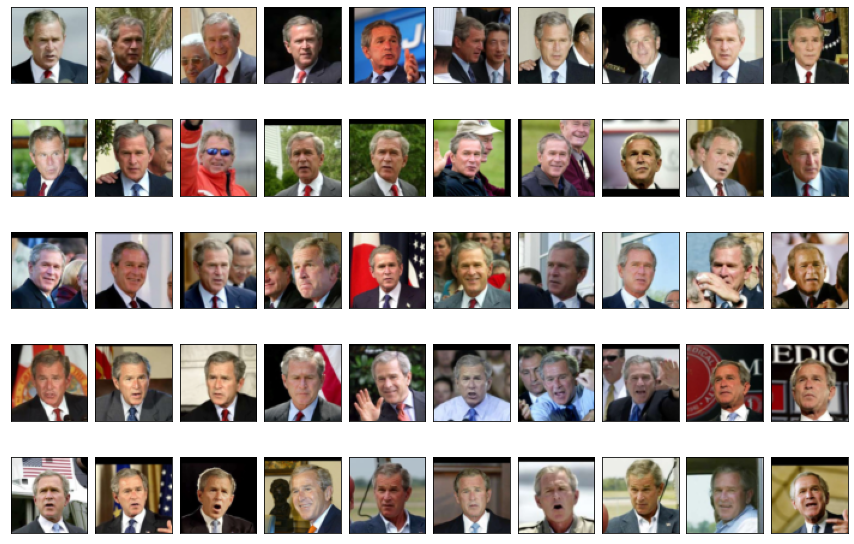

In [175]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [176]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [177]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (classifier_extractor): Sequential(
    (0): Linear(in_features=4096, out_features=4, bias=True)
    (1): LeakyReLU(negati

**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [178]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [179]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [180]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223, dtype=torch.float64)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

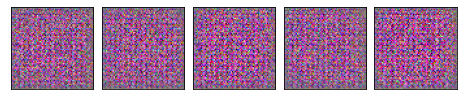

In [181]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [182]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0003}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0003}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.52it/s]
Discriminator loss: 0.9062487284342448
Generator loss:     0.9536062666651256
Saved checkpoint.


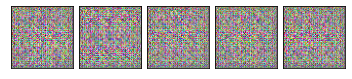

--- EPOCH 2/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
Discriminator loss: 0.4355900718106164
Generator loss:     1.7124550474088112
Saved checkpoint.


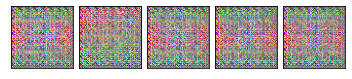

--- EPOCH 3/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.53it/s]
Discriminator loss: 0.3215772708257039
Generator loss:     2.3437493027119576
Saved checkpoint.


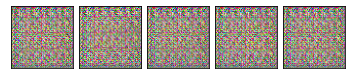

--- EPOCH 4/100 ---
100%|██████████| 9/9 [00:03<00:00,  2.97it/s]
Discriminator loss: 0.2972801427046458
Generator loss:     2.712998348448849
Saved checkpoint.


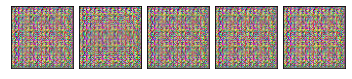

--- EPOCH 5/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.10it/s]
Discriminator loss: 0.26601725154452854
Generator loss:     3.121145143052332
Saved checkpoint.


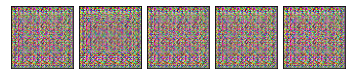

--- EPOCH 6/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.38it/s]
Discriminator loss: 0.20823487473858726
Generator loss:     3.279344019906243
Saved checkpoint.


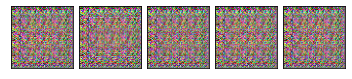

--- EPOCH 7/100 ---
100%|██████████| 9/9 [00:03<00:00,  2.87it/s]
Discriminator loss: 0.21948731856213677
Generator loss:     3.5146895966183056
Saved checkpoint.


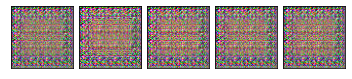

--- EPOCH 8/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.13it/s]
Discriminator loss: 0.21336906651655832
Generator loss:     3.564150148781449
Saved checkpoint.


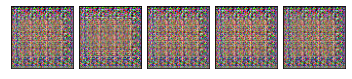

--- EPOCH 9/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.20it/s]
Discriminator loss: 0.12629289676745734
Generator loss:     3.4890556462541906
Saved checkpoint.


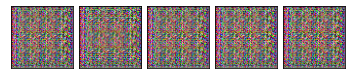

--- EPOCH 10/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.34it/s]
Discriminator loss: 0.19188375191556084
Generator loss:     3.9317137549579946
Saved checkpoint.


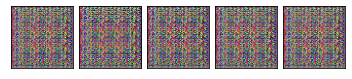

--- EPOCH 11/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.14it/s]
Discriminator loss: 0.17614022807942498
Generator loss:     3.6481566472945914
Saved checkpoint.


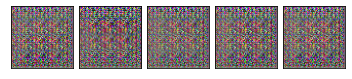

--- EPOCH 12/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.28it/s]
Discriminator loss: 0.1674774135980341
Generator loss:     4.236193322580989
Saved checkpoint.


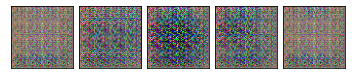

--- EPOCH 13/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.46it/s]
Discriminator loss: 0.3405083989103635
Generator loss:     4.003330025645089
Saved checkpoint.


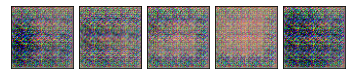

--- EPOCH 14/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.27it/s]
Discriminator loss: 0.2250527176592085
Generator loss:     3.3407816017066527
Saved checkpoint.


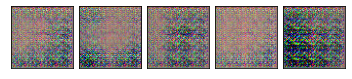

--- EPOCH 15/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.17it/s]
Discriminator loss: 0.22386696272426182
Generator loss:     3.3458851972774815
Saved checkpoint.


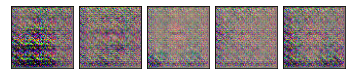

--- EPOCH 16/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.13it/s]
Discriminator loss: 0.9799816509087881
Generator loss:     2.986421357373052
Saved checkpoint.


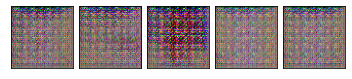

--- EPOCH 17/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.30it/s]
Discriminator loss: 0.8340511189566718
Generator loss:     2.946617194305984
Saved checkpoint.


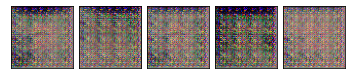

--- EPOCH 18/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.09it/s]
Discriminator loss: 0.5600489742226071
Generator loss:     2.0143179273870935
Saved checkpoint.


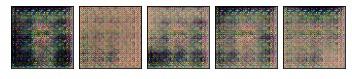

--- EPOCH 19/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.04it/s]
Discriminator loss: 0.693497273657057
Generator loss:     2.4879486063151752
Saved checkpoint.


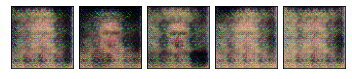

--- EPOCH 20/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.17it/s]
Discriminator loss: 0.7201483613914914
Generator loss:     2.4362474869050406
Saved checkpoint.


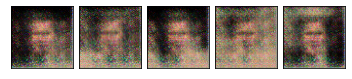

--- EPOCH 21/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.16it/s]
Discriminator loss: 0.8293906119134691
Generator loss:     2.0510910902962056
Saved checkpoint.


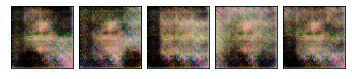

--- EPOCH 22/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.33it/s]
Discriminator loss: 1.3157880306243896
Generator loss:     2.6472276258935366
Saved checkpoint.


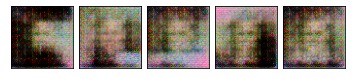

--- EPOCH 23/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.35it/s]
Discriminator loss: 0.9067118631468879
Generator loss:     1.343010984609446
Saved checkpoint.


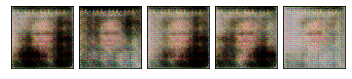

--- EPOCH 24/100 ---
100%|██████████| 9/9 [00:03<00:00,  2.93it/s]
Discriminator loss: 0.6147638029522366
Generator loss:     2.0111185198033144
Saved checkpoint.


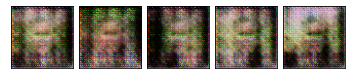

--- EPOCH 25/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
Discriminator loss: 1.5236151549551222
Generator loss:     1.7848684707661124
Saved checkpoint.


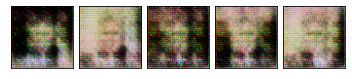

--- EPOCH 26/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.51it/s]
Discriminator loss: 1.2211646503872342
Generator loss:     1.096843753815596
Saved checkpoint.


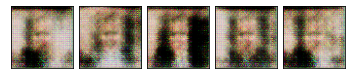

--- EPOCH 27/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.26it/s]
Discriminator loss: 0.9474873940149943
Generator loss:     1.493736636531661
Saved checkpoint.


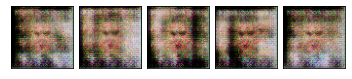

--- EPOCH 28/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.31it/s]
Discriminator loss: 0.9886878463957045
Generator loss:     1.7609012425851835
Saved checkpoint.


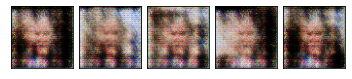

--- EPOCH 29/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.64it/s]
Discriminator loss: 0.9846917457050748
Generator loss:     1.9022190340238478
Saved checkpoint.


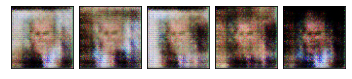

--- EPOCH 30/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.63it/s]
Discriminator loss: 1.1124664942423503
Generator loss:     1.7951747871896275
Saved checkpoint.


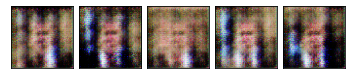

--- EPOCH 31/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.42it/s]
Discriminator loss: 1.001880341105991
Generator loss:     1.733802355749657
Saved checkpoint.


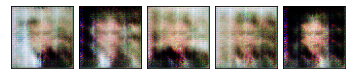

--- EPOCH 32/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.72it/s]
Discriminator loss: 0.954259196917216
Generator loss:     1.921326307149658
Saved checkpoint.


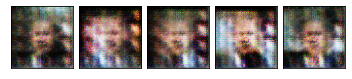

--- EPOCH 33/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.06it/s]
Discriminator loss: 1.1471103562249079
Generator loss:     1.769780768953603
Saved checkpoint.


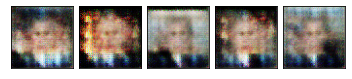

--- EPOCH 34/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.08it/s]
Discriminator loss: 0.935601896709866
Generator loss:     2.006234534814473
Saved checkpoint.


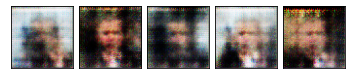

--- EPOCH 35/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.28it/s]
Discriminator loss: 1.1259699397616916
Generator loss:     1.6733997874372768
Saved checkpoint.


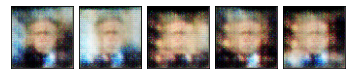

--- EPOCH 36/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.52it/s]
Discriminator loss: 1.4098109271791246
Generator loss:     1.7963210128128735
Saved checkpoint.


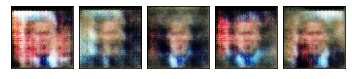

--- EPOCH 37/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.00it/s]
Discriminator loss: 1.1458174255159166
Generator loss:     0.9937735938176887
Saved checkpoint.


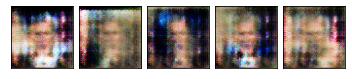

--- EPOCH 38/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.45it/s]
Discriminator loss: 1.0384555127885606
Generator loss:     1.5194523616756606
Saved checkpoint.


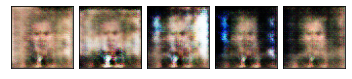

--- EPOCH 39/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.31it/s]
Discriminator loss: 0.9294066296683418
Generator loss:     1.8806778014468657
Saved checkpoint.


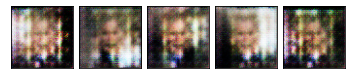

--- EPOCH 40/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.79it/s]
Discriminator loss: 0.9121948215696547
Generator loss:     1.8758269068299904
Saved checkpoint.


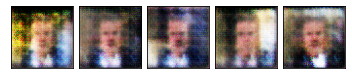

--- EPOCH 41/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.00it/s]
Discriminator loss: 0.9661029842164781
Generator loss:     1.7147570812215422
Saved checkpoint.


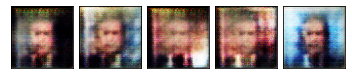

--- EPOCH 42/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.26it/s]
Discriminator loss: 1.0985782874955072
Generator loss:     1.7563085941429106
Saved checkpoint.


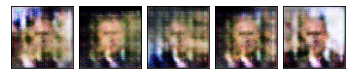

--- EPOCH 43/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.58it/s]
Discriminator loss: 1.0654399130079482
Generator loss:     1.635173906866616
Saved checkpoint.


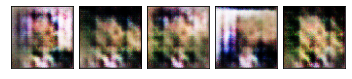

--- EPOCH 44/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.75it/s]
Discriminator loss: 0.8878553046120538
Generator loss:     1.7147659219944584
Saved checkpoint.


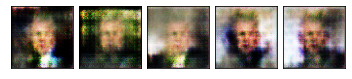

--- EPOCH 45/100 ---
100%|██████████| 9/9 [00:03<00:00,  2.91it/s]
Discriminator loss: 0.978429913520813
Generator loss:     1.8397104215495739
Saved checkpoint.


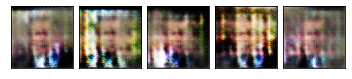

--- EPOCH 46/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.16it/s]
Discriminator loss: 1.0303560429149203
Generator loss:     1.830017562487731
Saved checkpoint.


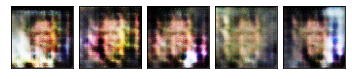

--- EPOCH 47/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
Discriminator loss: 1.598904463979933
Generator loss:     1.3514820510506251
Saved checkpoint.


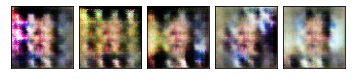

--- EPOCH 48/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.10it/s]
Discriminator loss: 1.0911470585399203
Generator loss:     1.1402265582133542
Saved checkpoint.


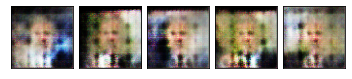

--- EPOCH 49/100 ---
100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
Discriminator loss: 0.9128939972983466
Generator loss:     1.4904279285157176
Saved checkpoint.


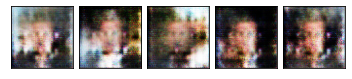

--- EPOCH 50/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 0.9681576821539137
Generator loss:     1.67469675096791
Saved checkpoint.


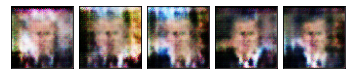

--- EPOCH 51/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.44it/s]
Discriminator loss: 0.8812593486573961
Generator loss:     1.900994142765062
Saved checkpoint.


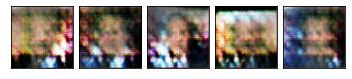

--- EPOCH 52/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 1.1076744463708665
Generator loss:     1.7018265133557473
Saved checkpoint.


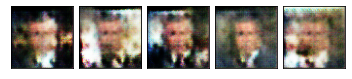

--- EPOCH 53/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 0.7414717276891073
Generator loss:     1.7482798529935932
Saved checkpoint.


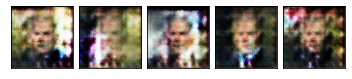

--- EPOCH 54/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.13it/s]
Discriminator loss: 1.2452536159091525
Generator loss:     1.7052393012585298
Saved checkpoint.


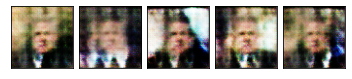

--- EPOCH 55/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.15it/s]
Discriminator loss: 0.8691073060035706
Generator loss:     1.4510498483175005
Saved checkpoint.


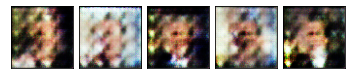

--- EPOCH 56/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.97it/s]
Discriminator loss: 0.6972127490573459
Generator loss:     2.0337283924339116
Saved checkpoint.


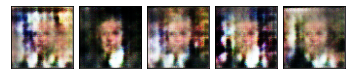

--- EPOCH 57/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.98it/s]
Discriminator loss: 1.4345231784714594
Generator loss:     1.7012612125412874
Saved checkpoint.


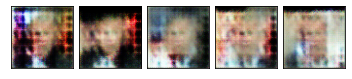

--- EPOCH 58/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.82it/s]
Discriminator loss: 0.9033861557642618
Generator loss:     1.675953649674897
Saved checkpoint.


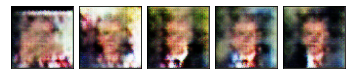

--- EPOCH 59/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.07it/s]
Discriminator loss: 1.002864784664578
Generator loss:     1.699937358069205
Saved checkpoint.


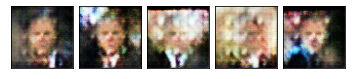

--- EPOCH 60/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.31it/s]
Discriminator loss: 0.9359853996170892
Generator loss:     1.6591094686761227
Saved checkpoint.


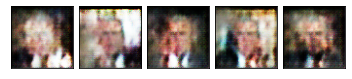

--- EPOCH 61/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 1.143020682864719
Generator loss:     1.575700410461297
Saved checkpoint.


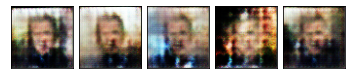

--- EPOCH 62/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
Discriminator loss: 0.9028813706503974
Generator loss:     1.8777583856943387
Saved checkpoint.


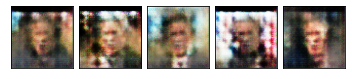

--- EPOCH 63/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
Discriminator loss: 1.0011472304662068
Generator loss:     1.6447265896343852
Saved checkpoint.


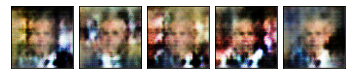

--- EPOCH 64/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.11it/s]
Discriminator loss: 0.8402647376060486
Generator loss:     1.7223690608888722
Saved checkpoint.


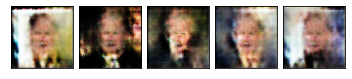

--- EPOCH 65/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.05it/s]
Discriminator loss: 1.2371103631125555
Generator loss:     1.9464991996530243
Saved checkpoint.


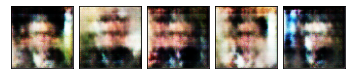

--- EPOCH 66/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
Discriminator loss: 0.9344954358206855
Generator loss:     1.3148926383414326
Saved checkpoint.


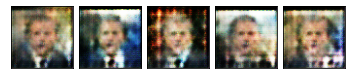

--- EPOCH 67/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
Discriminator loss: 0.8864287336667379
Generator loss:     1.7603687177694711
Saved checkpoint.


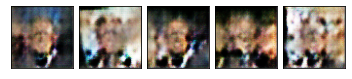

--- EPOCH 68/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
Discriminator loss: 0.9803426530626085
Generator loss:     1.8590652775139154
Saved checkpoint.


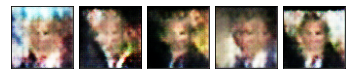

--- EPOCH 69/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 1.1149300932884216
Generator loss:     1.4286222135667401
Saved checkpoint.


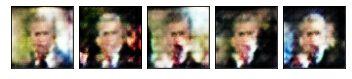

--- EPOCH 70/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
Discriminator loss: 0.7837860054439969
Generator loss:     1.8953447465165598
Saved checkpoint.


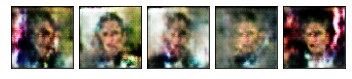

--- EPOCH 71/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
Discriminator loss: 0.6813012560208639
Generator loss:     1.8548532768970618
Saved checkpoint.


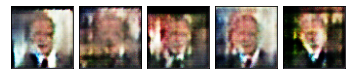

--- EPOCH 72/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.09it/s]
Discriminator loss: 1.2253806723488703
Generator loss:     1.7582964113325814
Saved checkpoint.


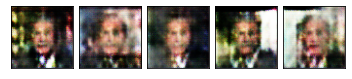

--- EPOCH 73/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
Discriminator loss: 1.2612858215967815
Generator loss:     1.6253497783545108
Saved checkpoint.


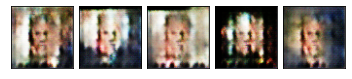

--- EPOCH 74/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.86it/s]
Discriminator loss: 0.7086500393019782
Generator loss:     1.409620526811453
Saved checkpoint.


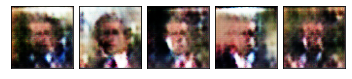

--- EPOCH 75/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.15it/s]
Discriminator loss: 0.7844366696145799
Generator loss:     1.8526991916178999
Saved checkpoint.


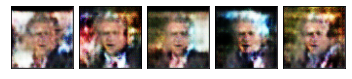

--- EPOCH 76/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
Discriminator loss: 0.9867911868625217
Generator loss:     1.7557244611201865
Saved checkpoint.


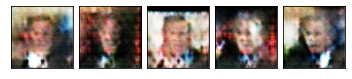

--- EPOCH 77/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.01it/s]
Discriminator loss: 0.8868861065970527
Generator loss:     1.8542163447666853
Saved checkpoint.


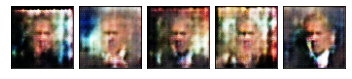

--- EPOCH 78/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
Discriminator loss: 0.8871477047602335
Generator loss:     1.7821106604887649
Saved checkpoint.


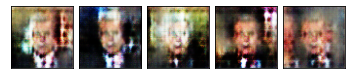

--- EPOCH 79/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.09it/s]
Discriminator loss: 0.7504325442843967
Generator loss:     1.8703663677197884
Saved checkpoint.


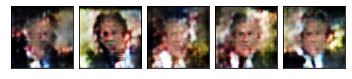

--- EPOCH 80/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.25it/s]
Discriminator loss: 0.9003213312890794
Generator loss:     1.853793056561094
Saved checkpoint.


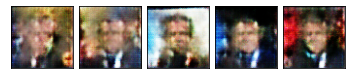

--- EPOCH 81/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.05it/s]
Discriminator loss: 0.6178929673300849
Generator loss:     1.8135160158441677
Saved checkpoint.


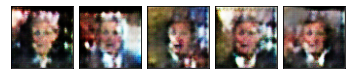

--- EPOCH 82/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.16it/s]
Discriminator loss: 1.1337334314982097
Generator loss:     2.042172292056492
Saved checkpoint.


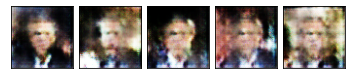

--- EPOCH 83/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.09it/s]
Discriminator loss: 0.6531642046239641
Generator loss:     1.686461297068246
Saved checkpoint.


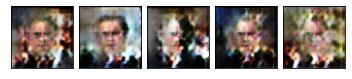

--- EPOCH 84/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.50it/s]
Discriminator loss: 0.6829030381308662
Generator loss:     2.1204845924698814
Saved checkpoint.


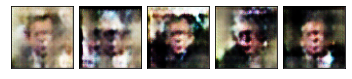

--- EPOCH 85/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.10it/s]
Discriminator loss: 0.7163823114501106
Generator loss:     1.8798865580443822
Saved checkpoint.


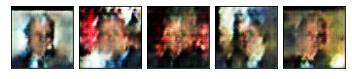

--- EPOCH 86/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.07it/s]
Discriminator loss: 0.63097326291932
Generator loss:     2.0003140991554345
Saved checkpoint.


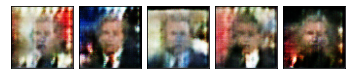

--- EPOCH 87/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.23it/s]
Discriminator loss: 0.9093501038021512
Generator loss:     2.0681537948951085
Saved checkpoint.


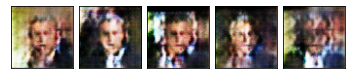

--- EPOCH 88/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.02it/s]
Discriminator loss: 0.6462110247876909
Generator loss:     2.0363304422145436
Saved checkpoint.


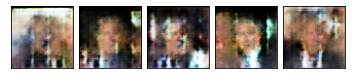

--- EPOCH 89/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
Discriminator loss: 0.7368823786576589
Generator loss:     2.14045608935413
Saved checkpoint.


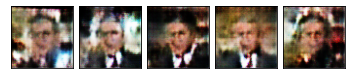

--- EPOCH 90/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
Discriminator loss: 1.2707916895548503
Generator loss:     1.7720070184350685
Saved checkpoint.


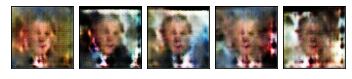

--- EPOCH 91/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.11it/s]
Discriminator loss: 0.8167349431249831
Generator loss:     1.7320641062775797
Saved checkpoint.


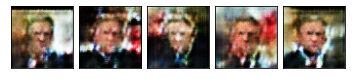

--- EPOCH 92/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 0.6240496403641171
Generator loss:     1.8690653505827208
Saved checkpoint.


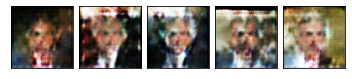

--- EPOCH 93/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
Discriminator loss: 1.0194992356830173
Generator loss:     1.9399497887983381
Saved checkpoint.


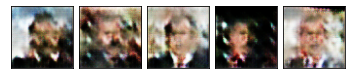

--- EPOCH 94/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.93it/s]
Discriminator loss: 0.6800740427441068
Generator loss:     1.9028339306900692
Saved checkpoint.


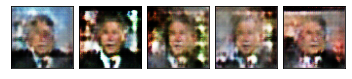

--- EPOCH 95/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
Discriminator loss: 0.6202112171385024
Generator loss:     1.9320121497170106
Saved checkpoint.


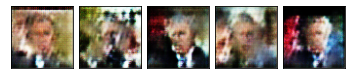

--- EPOCH 96/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
Discriminator loss: 0.5359085732036166
Generator loss:     2.0008864024607838
Saved checkpoint.


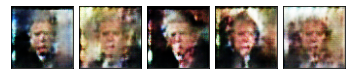

--- EPOCH 97/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 0.6875519322024451
Generator loss:     2.226363144707824
Saved checkpoint.


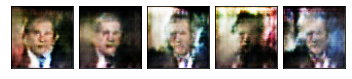

--- EPOCH 98/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.00it/s]
Discriminator loss: 0.9697658088472154
Generator loss:     2.009115356996595
Saved checkpoint.


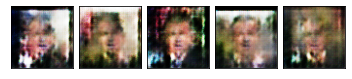

--- EPOCH 99/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.643678691652086
Generator loss:     2.2151572463147957
Saved checkpoint.


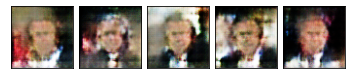

--- EPOCH 100/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 1.07528555393219
Generator loss:     1.9833924416586077
Saved checkpoint.


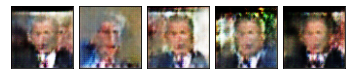

In [183]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


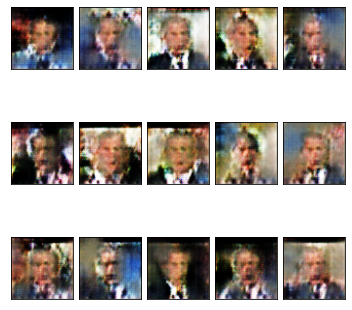

In [184]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [185]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [186]:
display_answer(hw3.answers.part3_q1)


**Your answer:**

We maintain the gradient when we train the generator and we ignore it when training the discriminator. We give the discriminator fake data without maintaining the gradient in order to avoid updating the generator's parameters so we can train the generator "seperately". 



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [187]:
display_answer(hw3.answers.part3_q2)


**Your answer:**

1. When training we saw the losses going up and down very frequently. It is caused due to the favt that the model is not trained enough: it may recieve very poor data but, getting a very loss value but we cannot rely on this results as the model is not trained. Therefore, implementing an early stopping solely based on the fact that the Generator loss is below some threshold is wrong.

2. It means that the discriminator is learning well and classifies the data better, as for a more realistic generated data we are getting the same discriminator loss. As explained above, it takes time to train the discriminator and therefore it may be more inaccurate at the beginning. 



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [188]:
display_answer(hw3.answers.part3_q3)


**Your answer:**

The images in VAE show some average image, and the results do not differ greatly from each other. Every picture we got in the dataset, the face of president Bush is there. The model concentrate on the face, but concentrates less on the background. It happens because VAE compresses the sample and reconstructs it, and the most common thing the model sees is the face of Bush. 

On the other hand, GAN generates more colourful pictures but blurred face. It happens because in GAN we generate samples and train the generator and discriminator on them, without paying attention to any specific similarity between the pictures. 


